# Rede Neural Recorrente simples para classificar dígitos MNIST

O experimento deste notebook foi modificado para ser uma RNN sequencial 
com 28 linhas de 28 pixels para cada amostra. O experimento original
trata um pixel de cada vez.

**Obs:** This is a reproduction of the IRNN experiment
with pixel-by-pixel sequential MNIST in
"A Simple Way to Initialize Recurrent Networks of Rectified Linear Units"
by Quoc V. Le, Navdeep Jaitly, Geoffrey E. Hinton
arxiv:1504.00941v2 [cs.NE] 7 Apr 2015
http://arxiv.org/pdf/1504.00941v2.pdf
Optimizer is replaced with RMSprop which yields more stable and steady
improvement.
Reaches 0.93 train/test accuracy after 900 epochs
(which roughly corresponds to 1687500 steps in the original paper.)

## Importação

In [1]:
import sys,os 
import numpy as np

import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import SimpleRNN, LSTM
from keras import initializers
from keras.optimizers import RMSprop, Adadelta

sys.path.append('../src')
from my_keras_utilities import (get_available_gpus, 
                                load_model_and_history, 
                                save_model_and_history, 
                                TrainingPlotter)

Using TensorFlow backend.


In [2]:
import keras.backend as K
# K.set_image_data_format('channels_first')
K.set_floatx('float32')
print('Backend:        {}'.format(K.backend()))
print('Data format:    {}'.format(K.image_data_format()))
print('Available GPUS:', get_available_gpus())
!nvidia-smi

Backend:        tensorflow
Data format:    channels_last
Available GPUS: []
/bin/sh: nvidia-smi: command not found


In [3]:
class MyCb(TrainingPlotter):
    
    def on_epoch_end(self, epoch, logs={}):
        super().on_epoch_end(epoch, logs)


def train_network(model, X_train, y_train, Xval, yval, 
                  model_name = None,
                  loss="categorical_crossentropy",
                  opt='rmsprop', batch_size=60, nepochs=100, patience=10, nr_seed=20170522, 
                  reset=False, ploss=1.0):

    do_plot = (ploss > 0.0)
    
    model_fn = model_name + '.model'
    if reset and os.path.isfile(model_fn):
        os.unlink(model_name + '.model')
        
    if not os.path.isfile(model_fn):
        # initialize the optimizer and model
        print("[INFO] compiling model...")
        model.compile(loss=loss, optimizer=opt, metrics=["accuracy"])    

        # History, checkpoint, earlystop, plot losses:
        cb = MyCb(n=1, filepath=model_name, patience=patience, plot_losses=do_plot)
        
    else:
        print("[INFO] loading model...")
        model, cb = load_model_and_history(model_name)
        cb.patience = patience

    past_epochs = cb.get_nepochs()
    tr_epochs = nepochs - past_epochs
    
    if do_plot:
        import matplotlib.pyplot as plot
        vv = 0
        fig = plot.figure(figsize=(15,6))
        plot.ylim(0.0, ploss)
        plot.xlim(0, nepochs)
        plot.grid(True)
    else:
        vv = 2

    print("[INFO] training for {} epochs...".format(tr_epochs))
    try:
        h = model.fit(X_train, y_train, batch_size=60, epochs=tr_epochs, verbose=0, 
                      validation_data=(Xval, yval), callbacks=[cb])
    except KeyboardInterrupt:
        pass

    return model, cb

def test_network(model_name, X_test, y_test):
    model, histo = load_model_and_history(model_name)
    print('Model from epoch {}'.format(histo.best_epoch))
    print("[INFO] evaluating in the test data set ...")
    loss, accuracy = model.evaluate(X_test, y_test, batch_size=128, verbose=1)
    print("\n[INFO] accuracy on the test data set: {:.2f}% [{:.5f}]".format(accuracy * 100, loss))


## Leitura do dataset

In [4]:
(x_train_all, y_train_all), (x_test_all, y_test_all) = mnist.load_data()
print(x_train_all.shape,y_train_all.shape)
print(x_test_all.shape)

(60000, 28, 28) (60000,)
(10000, 28, 28)


## Pouquíssimas amostras - depurando apenas

In [5]:
n_samples = 6000
n_valid_samples = 1000

x_train = x_train_all[:n_samples]
y_train = y_train_all[:n_samples]
x_test = x_test_all[:n_valid_samples]
y_test = y_test_all[:n_valid_samples]

## Normalização dos dados

In [6]:
x_train = x_train.reshape(x_train.shape[0], -1, 1)
x_test = x_test.reshape(x_test.shape[0], -1, 1)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (6000, 784, 1)
6000 train samples
1000 test samples


## Codificação One-hot das classes da saída 

In [7]:
num_classes = 10
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [8]:
x_train = x_train.reshape(-1,28,28)
x_test  = x_test.reshape(-1,28,28)

In [60]:
print(x_train.shape[1:])

(28, 28)


## SimpleRNN com 100 neurônios

In [9]:
model = Sequential()
model.add(SimpleRNN(100,
                    kernel_initializer=initializers.RandomNormal(stddev=0.001),
                    recurrent_initializer=initializers.Identity(gain=1.0),
                    activation='relu',
                    input_shape=x_train.shape[1:]))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_1 (SimpleRNN)     (None, 100)               12900     
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1010      
_________________________________________________________________
activation_1 (Activation)    (None, 10)                0         
Total params: 13,910
Trainable params: 13,910
Non-trainable params: 0
_________________________________________________________________
None


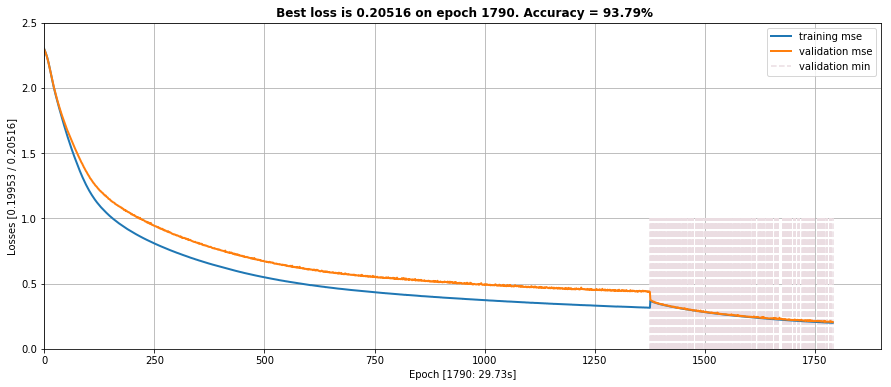

In [62]:
model_name = '../../models/SimpleRNN_MNIST'
fit_params = {
    'model_name': model_name,
    'loss': 'categorical_crossentropy',
    'opt':        RMSprop(lr=1e-6),
    'batch_size': 32, 
    'nepochs':    1900,
    'patience':   15,
    'ploss':      2.5,
    'reset':      False,
}

train_network(model, x_train, y_train, x_test, y_test, **fit_params);

In [52]:
test_network(model_name, x_test, y_test)

Model from epoch 898
[INFO] evaluating in the test data set ...
1664/2000 [=======================>......] - ETA: 0s
[INFO] accuracy on the test data set: 83.65% [0.51077]


In [53]:
yhat = model.predict(x_test[0:1])

In [50]:
yhat

array([[ 0.0756877 ,  0.05469039,  0.11312167,  0.11700404,  0.10506554,
         0.08659822,  0.08116689,  0.13337751,  0.11143868,  0.12184935]], dtype=float32)